In [1]:
import numpy as np
from itertools import cycle
import os

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import datetime as dt
import subprocess
from scipy.ndimage import binary_fill_holes
from importlib import reload
os.chdir("/home/149/ab8992/cosima_regional/regional-mom6/")

import regional_mom6 as rm
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41169,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:41325,Total threads: 2
Dashboard: /proxy/33827/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:39393,


## Set up a RYF run from the 20th degree output and ERA5

The boundary forcing would probably still be GLORYS since otherwise we just introduce the biases and boundary effects of the mom6 run. The IC would be from the 20th degree after spinup, and the surface foring would be ERA5. The question is though how much smoothing is required to ensure there's no massive shock?

# First, check the ERA5 data at the start and end of the year

In [86]:
era5 = xr.open_mfdataset('/g/data/nm03/ab8992/ttide-inputs/era5/*',decode_times=False).isel(time = slice(0,24 * 365))

def diff(da,time):
    return np.abs(da.isel(time = time) - da.isel(time = time-1)).mean("latitude").mean("longitude").values

def maxdiff(da,time):
    return np.abs(da.isel(time = time) - da.isel(time = time-1)).max("latitude").max().values
print("var\tmean diff\tmax diff")

for i in era5.data_vars:
    print(i,end = "\t")
    print(round(100 * diff(era5[i],120) / diff(era5[i],0)) , "%\t\t",round(100 * maxdiff(era5[i],120) / maxdiff(era5[i],0)) , "% ",sep="")


var	mean diff	max diff
q	6%		15% 
sp	2%		4% 
t2m	18%		46% 
u10	6%		32% 
v10	8%		22% 


The jolt is ~5-20 times bigger than the usual change day to day on average. This can hopefully be fixed by smoothing over a 10 day window or so...

## Smooth the last and first weeks of the ERA5 forcing together

Two week overlap. Try two hyperbolic tangents? Let $T_0$ be the seam in the data. 

$ \large f'(t) = \frac{1}{2} \left( 1 + \tanh{\left(\frac{f(t) \pi}{\sigma} \right)} \right) + \frac{1}{2} \left( 1 + \tanh{\left(\frac{f(-t) \pi}{\sigma} \right)} \right)$

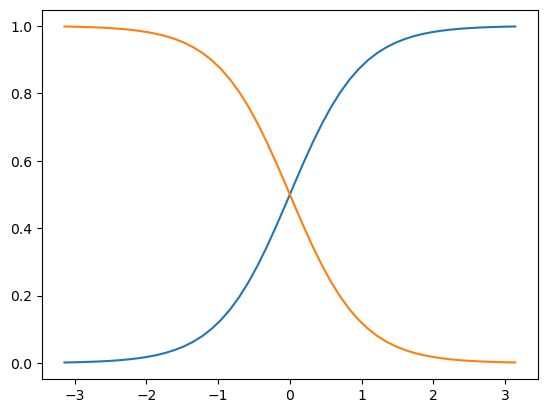

In [30]:
import numpy as np
dt = 10
endtime = 100

plt.plot(np.linspace(-np.pi,np.pi,50),0.5 * np.tanh(np.linspace(-np.pi,np.pi,50)) + 0.5)
plt.plot(np.linspace(-np.pi,np.pi,50),0.5 * np.tanh(-1 * np.linspace(-np.pi,np.pi,50)) + 0.5)


In [ ]:
def smooth_ends(da,dt):
    """
    Using a tanh function, smooth the ends of a data array. Takes the time window - dt to + dt.
    """

    endtime = da.time.values[-1]

    start_window = era5.isel(time = slice(0,dt))
    end_window = era5.isel(time = slice(-dt,None))

    


    da.isel(time = slice(0,dt,)).values = 0.5 * np.tanh(np.linspace(-np.pi,np.pi,dt)) + 0.5

def linfit(da,dt):
    

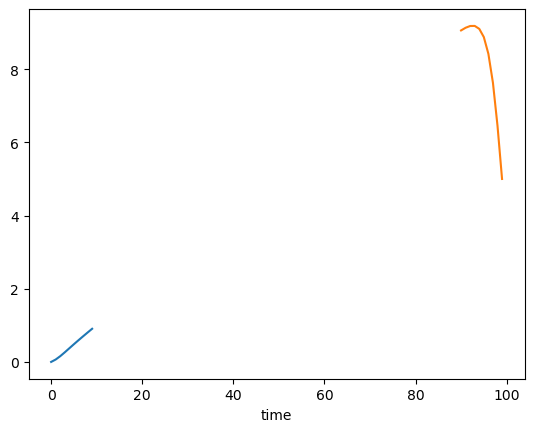

In [83]:
dt = 10

da = xr.DataArray(
    data = np.linspace(0,10,100),
    dims = {"time":np.arange(0,100,1)},
    coords = {"time":np.arange(0,100,1)},
)


lasttime = da.time.values[-1]

startw = da.isel(time = slice(0,dt)) * 0.5 * (1 + np.tanh(da.time * np.pi / dt))
endw = da.isel(time = slice(-dt,None)) * 0.5 * (1 + np.tanh((lasttime -1 * da.time) * np.pi / dt))

linear_fit = 

da.loc[{"time":0}] = da.loc[{"time":0}] * 0.5

startw.plot()
endw.plot()


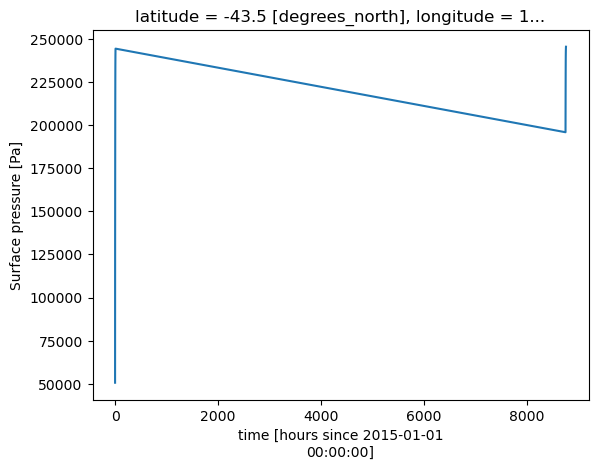

In [62]:
# Get the last 10 and first 10 time points
last_10 = era5.sp.isel(latitude = 50,longitude = 50,time=slice(-10, None))
first_10 = era5.sp.isel(latitude = 50,longitude = 50,time=slice(None, 10))

# Concatenate the two DataArrays along the time dimension
result = xr.concat([first_10, last_10], dim='time')

# Now you can plot the result
result.plot()